## Read in the data

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Configure matplotlib to display plots inline
%matplotlib inline

# Configure the default style for seaborn and matplotlib
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')

# List of dataset filenames
data_files = [
    "ap_2010.csv",         # Data on AP test results
    "class_size.csv",      # Data on class size
    "demographics.csv",    # Data on demographics
    "graduation.csv",      # Data on graduation outcomes
    "hs_directory.csv",    # Directory of high schools
    "sat_results.csv"      # Data on SAT scores
]

# Dictionary to store dataframes
data = {}

# Loop through each file in the data_files list
for f in data_files:
    # Read the CSV file into a Pandas dataframe
    d = pd.read_csv("schools/{0}".format(f))
    # Store the dataframe in the dictionary with the file name (without .csv) as the key
    data[f.replace(".csv", "")] = d

## Read in the surveys

In [5]:
# Read the survey files
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')

# Concatenate the two survey datasets along the rows
survey = pd.concat([all_survey, d75_survey], axis=0)

# Define a list of columns to keep from the survey data, including 'DBN' which will be a duplicate of 'dbn'
survey_fields = [
    "dbn",          # School identifier
    "rr_s",         # Response rate student
    "rr_t",         # Response rate teacher
    "rr_p",         # Response rate parent
    "N_s",          # Number of student responses
    "N_t",          # Number of teacher responses
    "N_p",          # Number of parent responses
    "saf_p_11",     # Safety and Respect score from parents (2011)
    "com_p_11",     # Communication score from parents (2011)
    "eng_p_11",     # Engagement score from parents (2011)
    "aca_p_11",     # Academic expectations score from parents (2011)
    "saf_t_11",     # Safety and Respect score from teachers (2011)
    "com_t_11",     # Communication score from teachers (2011)
    "eng_t_11",     # Engagement score from teachers (2011)
    "aca_t_11",     # Academic expectations score from teachers (2011)
    "saf_s_11",     # Safety and Respect score from students (2011)
    "com_s_11",     # Communication score from students (2011)
    "eng_s_11",     # Engagement score from students (2011)
    "aca_s_11",     # Academic expectations score from students (2011)
    "saf_tot_11",   # Total Safety and Respect score (2011)
    "com_tot_11",   # Total Communication score (2011)
    "eng_tot_11",   # Total Engagement score (2011)
    "aca_tot_11"    # Total Academic expectations score (2011)
]

# Select only the columns of interest from the survey data
survey = survey[survey_fields]

# Rename the 'dbn' column to 'DBN' to maintain consistency with other datasets
survey = survey.rename(columns={"dbn": "DBN"})

# Store the cleaned and filtered survey data in the 'data' dictionary
data["survey"] = survey

## Add DBN columns

In [7]:
# Add a 'DBN' column to the 'hs_directory' dataset by copying the 'dbn' column
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

# Function to pad the CSD (Community School District) number with a leading zero if needed
def pad_csd(num):
    string_representation = str(num)  # Convert the number to a string
    if len(string_representation) > 1:  # If the length is greater than 1, return the string as is
        return string_representation
    else:
        return "0" + string_representation  # Otherwise, pad with a leading zero

# Apply the pad_csd function to the 'CSD' column of the 'class_size' dataset to create a new 'padded_csd' column
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)

# Create a 'DBN' column in the 'class_size' dataset by concatenating the 'padded_csd' and 'SCHOOL CODE' columns
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

## Convert columns to numeric

In [9]:
# List of columns in 'sat_results' to convert to numeric types
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']

# Convert each specified column in 'sat_results' to a numeric data type, coercing errors to NaN
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

# Calculate the total SAT score by summing the three individual scores, and store it in a new column 'sat_score'
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

# Function to extract latitude from the 'Location 1' column in 'hs_directory'
def find_lat(loc):
    coords = re.findall(r"\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

# Function to extract longitude from the 'Location 1' column in 'hs_directory'
def find_lon(loc):
    coords = re.findall(r"\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

# Apply the 'find_lat' and 'find_lon' functions to extract latitude and longitude,
# and create new 'lat' and 'lon' columns in 'hs_directory'
data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

# Convert the 'lat' and 'lon' columns in 'hs_directory' to a numeric data type
data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

## Condense datasets

In [11]:
# Filter 'class_size' to include only high school grades and general education programs
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

# Group by 'DBN' and take the mean of each group to condense the dataset
class_size = class_size.groupby("DBN").agg("mean", numeric_only=True)  # Use the string "mean" instead of np.mean
class_size.reset_index(inplace=True)  # Reset the index to turn 'DBN' back into a column
data["class_size"] = class_size  # Update the data dictionary with the condensed dataset

# Filter 'demographics' to include data only for the 2011-2012 school year
data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

# Filter 'graduation' to focus on the 2006 cohort and total demographic group
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

## Convert AP scores to numeric

In [13]:
# List of columns in the 'ap_2010' dataset to convert to numeric
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

# Convert each specified column in 'ap_2010' to a numeric data type
for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

## Combine the datasets

In [15]:
pd.set_option('future.no_silent_downcasting', True)

# Start with the 'sat_results' dataset as the base for combining
combined = data["sat_results"]

# Merge the 'ap_2010' dataset into 'combined' on the 'DBN' column, using a left join to keep all SAT results
combined = combined.merge(data["ap_2010"], on="DBN", how="left")

# Merge the 'graduation' dataset into 'combined' on the 'DBN' column, also using a left join
combined = combined.merge(data["graduation"], on="DBN", how="left")

# List of datasets to merge with 'combined'
to_merge = ["class_size", "demographics", "survey", "hs_directory"]

# Iterate through the list and merge each dataset into 'combined' using an inner join to keep only common DBNs
for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

# Fill any remaining missing values in numeric columns with the mean of their columns
combined = combined.fillna(combined.mean(numeric_only=True))

# Replace any remaining NaN values with 0, then infer the most appropriate data types
combined = combined.fillna(0).infer_objects(copy=False)

## Add a school district column for mapping

In [17]:
# Create a de-fragmented copy of the DataFrame
combined = combined.copy()

# Create the 'school_dist' column by slicing the first two characters of the 'DBN' column
combined["school_dist"] = combined["DBN"].str[:2]

## Find correlations

In [19]:
# Compute the correlation values for the 'sat_score' column
correlations = combined.select_dtypes(include=[float, int]).corr()["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


## Plotting survey correlations

In [21]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("dbn")

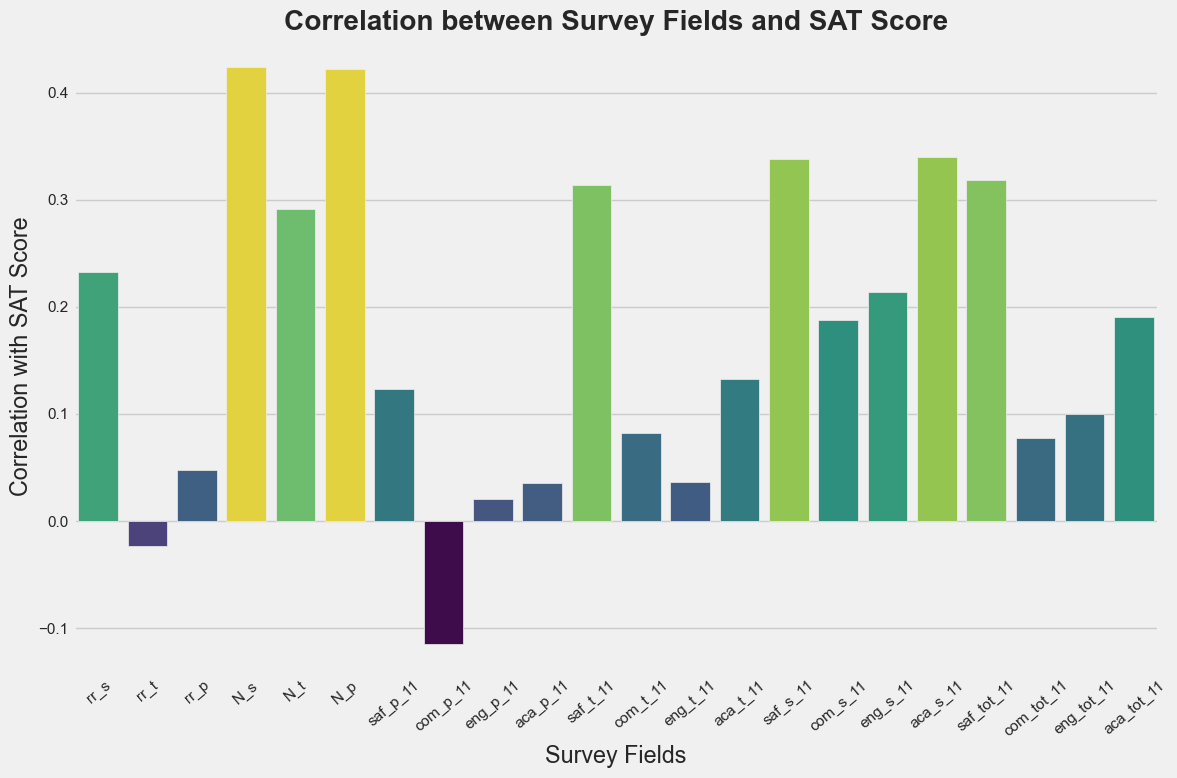

In [48]:
# Filter the combined dataset to include only the relevant columns plus 'sat_score'
filtered_combined = combined[['sat_score'] + survey_fields]

# Extract the correlations of the survey fields with 'sat_score'
survey_fields_correlations = filtered_combined.corr()["sat_score"].drop("sat_score")

# Create a bar plot of these correlations
plt.figure(figsize=(12, 8))
sns.barplot(x=survey_fields_correlations.index,
            y=survey_fields_correlations.values,
            palette="viridis",
            hue=survey_fields_correlations.values,
            legend=False)

# Add labels and title
plt.xlabel('Survey Fields')
plt.ylabel('Correlation with SAT Score')
plt.title('Correlation between Survey Fields and SAT Score', weight='bold')
plt.xticks(rotation=40)  # Rotate x-axis labels for better readability

# Show the plot
plt.tight_layout()
plt.show()

## Analysis of Correlations with SAT Scores

#### Notable Positive Correlations:
- **`N_s` (Number of Student Respondents)**: `0.423`  
  Schools with more student respondents tend to have higher SAT scores.
  
- **`N_p` (Number of Parent Respondents)**: `0.422`  
  Schools with more parent respondents also tend to have better SAT scores.
  
- **`saf_s_11` (Safety and Respect Score from Students)**: `0.338`  
  Higher student perceptions of safety and respect are positively related to SAT scores.
  
- **`aca_s_11` (Academic Expectations Score from Students)**: `0.339`  
  Positive correlation with SAT scores indicates that students' views on academic expectations impact performance.

#### Unexpected Low or Negative Correlations:
- **`rr_t` (Teacher Response Rate)**: `-0.023`  
  Negligible or slightly negative correlation suggests minimal impact on SAT scores.

- **`com_p_11` (Communication Score from Parents)**: `-0.115`  
  A negative correlation implies that better communication scores from parents are weakly associated with SAT performance.

These insights reveal that student and parent engagement, along with perceptions of safety and academic expectations, have stronger correlations with SAT scores than teacher response rates and parent communication scores.

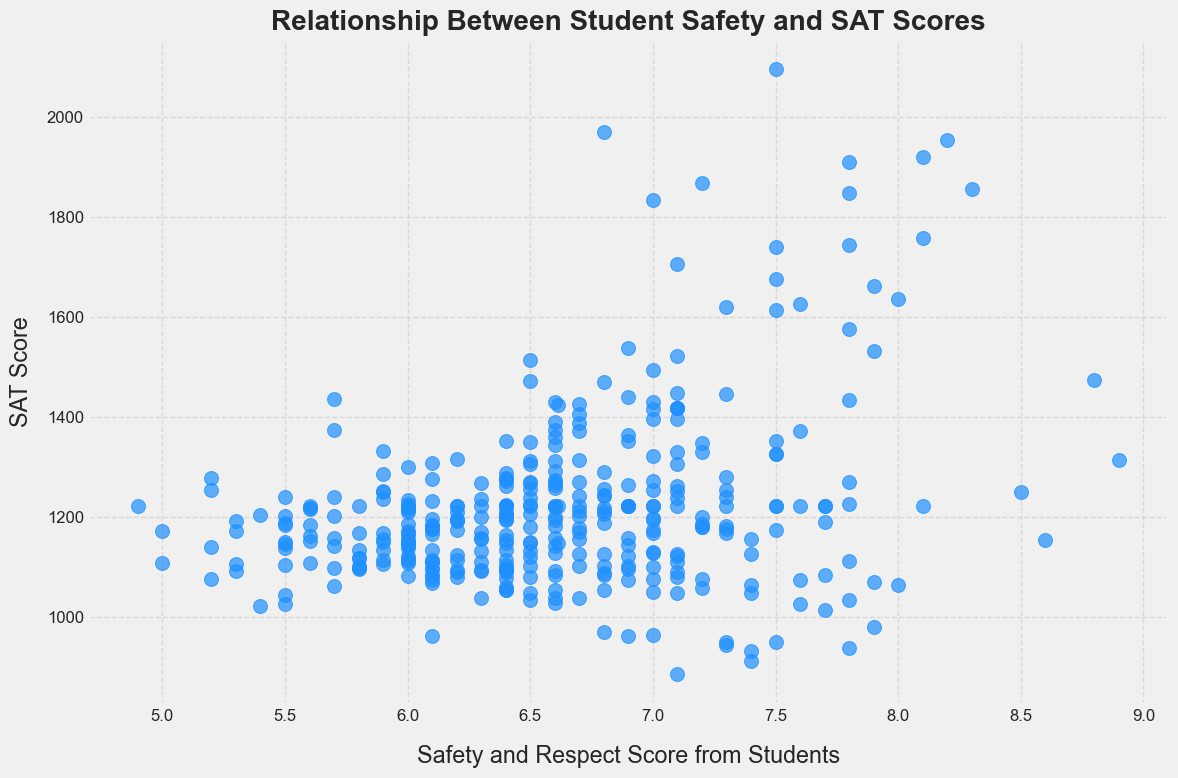

In [24]:
# Create the scatterplot
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=combined,
    x="saf_s_11",
    y="sat_score",
    color="dodgerblue",
    s=100,
    edgecolor=None,
    alpha=0.7
)

# Add titles and labels with styling
plt.title("Relationship Between Student Safety and SAT Scores", fontweight='bold')
plt.xlabel("Safety and Respect Score from Students", labelpad=15)
plt.ylabel("SAT Score", labelpad=10)

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Customize the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a tight layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()

## Analysis of Student Safety and SAT Scores

### Scatterplot Insights

- **Positive Trend**: Higher student safety and respect scores are generally associated with higher SAT scores, suggesting that a safer and more respectful school environment may boost academic performance.
- **Variation and Outliers**: There is noticeable variation and some outliers, indicating that while safety scores are positively correlated with SAT scores, other factors also influence academic performance.

### Conclusions

- **Correlation**: The positive correlation underscores the importance of a supportive school environment in achieving better SAT scores.
- **Complexity**: The variation and outliers highlight that student safety is one of several factors affecting SAT performance.
- **Recommendation**: Enhancing safety and respect in schools could contribute to improved academic outcomes, but should be part of a broader strategy addressing multiple influences on performance.

This scatterplot suggests that improving student safety can positively impact SAT scores, though it is not the sole factor in academic success.

In [25]:
boroughs_grouped = pd.DataFrame(
    {
        "Mean safety": combined.groupby("boro").agg("mean", numeric_only=True)["saf_s_11"],
        "Values counts": combined["boro"].value_counts()
    }
)
boroughs_grouped.index.name = "Borough"
boroughs_grouped.reset_index(inplace=True)
print(boroughs_grouped)

         Borough  Mean safety  Values counts
0          Bronx     6.606577             93
1       Brooklyn     6.370755            106
2      Manhattan     6.831370             90
3         Queens     6.721875             64
4  Staten Island     6.530000             10


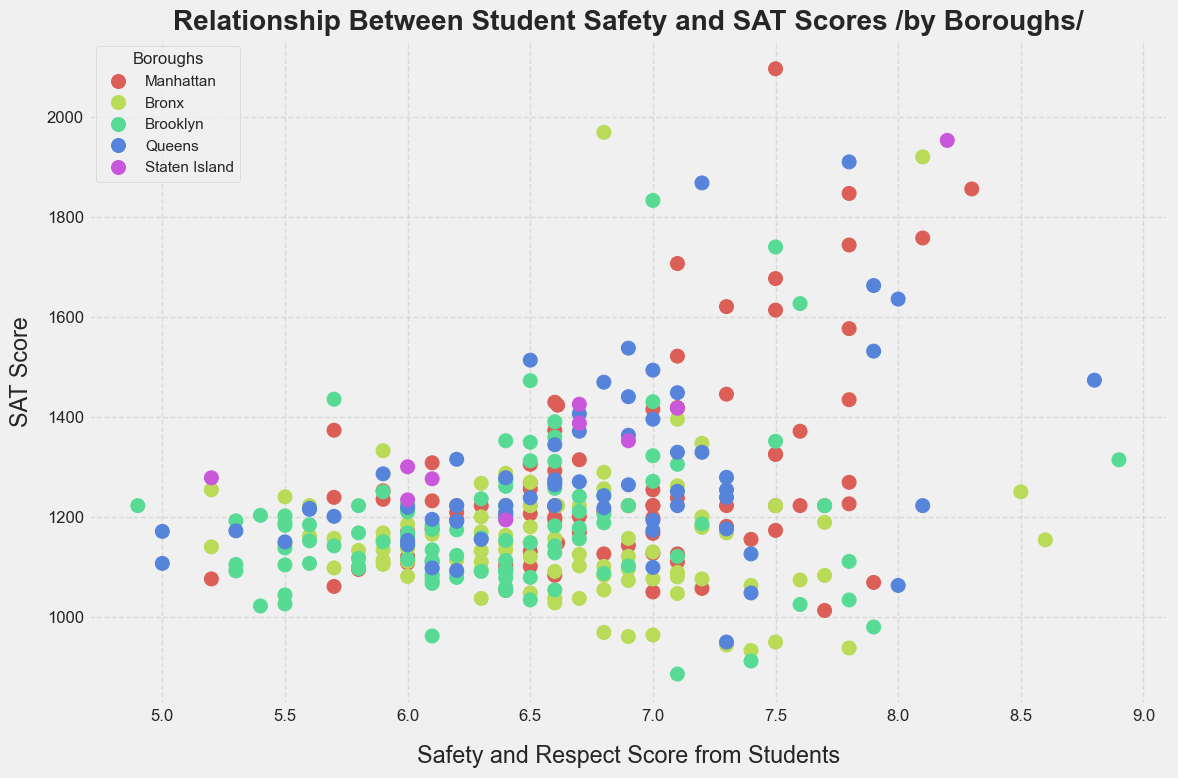

In [26]:
# Create the scatterplot
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=combined,
    x="saf_s_11",
    y="sat_score",
    hue="boro",
    palette=sns.color_palette("hls", 5),
    #palette=sns.color_palette("Spectral"),
    s=100,
    edgecolor=None,
    #alpha=0.7
)

# Add titles and labels with styling
plt.title("Relationship Between Student Safety and SAT Scores /by Boroughs/", fontweight='bold')
plt.xlabel("Safety and Respect Score from Students", labelpad=15)
plt.ylabel("SAT Score", labelpad=10)

plt.legend(title='Boroughs', loc='upper left')

# Add a grid for better readability
plt.grid(True, linestyle='--', alpha=0.6)

# Customize the ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a tight layout to ensure everything fits well
plt.tight_layout()

# Show the plot
plt.show()